In [2]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, r2_score
import sklearn

In [3]:
df = pd.read_csv('full.csv')

In [5]:
def scale_df(df):
    df = df.astype(float)
    names = df.columns
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    scaled_df = scaler.fit_transform(df)
    df = pd.DataFrame(scaled_df, columns=names)
    
    return df

In [4]:
def split_data(df):
    y = df.iloc[:, df.columns == 'TOTAL']
    X = df.iloc[:, df.columns != 'TOTAL']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
        test_size=0.5, random_state=123) 
    

    return X_train, X_val, y_train, y_val

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


In [7]:
 X_train, X_val, y_train, y_val = split_data(df)

### Decision tree

Feature: LATITUDE, Score: 0.15194
Feature: LONGITUD, Score: 0.10808
Feature: PDMEAN, Score: 0.32761
Feature: sf_depth, Score: 0.11042
Feature: PCO2.H2O_mmm, Score: 0.00908
Feature: PCO2.CO2_umm, Score: 0.01286
Feature: NMEA.Humidity, Score: 0.02494
Feature: NMEA.Trykk, Score: 0.03582
Feature: FerryBox.SBE45_Salinity, Score: 0.01578
Feature: FerryBox.Optode_Saturation, Score: 0.02887
Feature: FerryBox.C3_Turbidity, Score: 0.05855
Feature: FerryBox.C3_CHLAFluorescence, Score: 0.00482
Feature: FerryBox.C3_Temperature, Score: 0.02482
Feature: FerryBox.C3_CDOMFluorescence, Score: 0.00832
Feature: day, Score: 0.01782
Feature: month, Score: 0.00038
Feature: time, Score: 0.05990


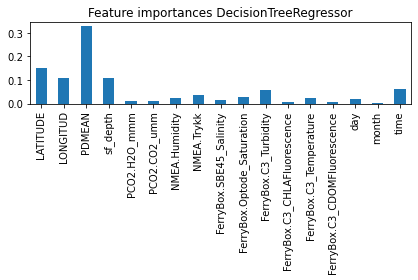

In [8]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: %s, Score: %.5f' % (X_train.columns[i],v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
importances = pd.Series(importance, index=X_train.columns)

fig, ax = plt.subplots()
importances.plot.bar([x for x in range(len(importance))], importance)
ax.set_title("Feature importances DecisionTreeRegressor")
fig.tight_layout()
plt.show()


In [9]:
y_pred = model.predict(X_val)

In [10]:
print('MAE score: ', mean_absolute_error(y_val, y_pred))
print('R2 score: ', r2_score(y_val, y_pred))
print('Smape score: ', smape(y_val, y_pred.reshape(len(X_val,1)))

MAE score:  19.31581299352114
R2 score:  0.5066267735876451
Smape score:  TOTAL    0.33328
dtype: float64


### Random Forest

In [ ]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train.values.ravel())
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

In [ ]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
forest_pred = forest.predict(X_val)

In [ ]:
print('MAE score: ', mean_absolute_error(y_val, forest_pred))
print('R2 score: ', r2_score(y_val, forest_pred))
print('Smape score: ', smape(y_val, forest_pred.reshape(len(X_val,1)))

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Partial Least Squares 

In [ ]:
#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

# Calculate MAPE using cross-validation, adding one component at a time
for i in np.arange(1, 18):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_absolute_error').mean()
    mse.append(score)

#plot test MAPE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MAE')
plt.xlim((1,16))
plt.title('Total')

In [ ]:
pls = PLSRegression(n_components=9)
pls.fit(X_train, y_train)

In [ ]:
pls_pred = pls.predict(X_val)

In [ ]:
print('MAE score: ', mean_absolute_error(y_val, pls_pred))
print('R2 score: ', r2_score(y_val, pls_pred))
print('Smape score: ', smape(y_val, pls_pred.reshape(len(X_val,1)))